# Implementing VGG-16 on Cat vs Dog Dataset

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

<img src = "https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width = 700>

### Importing required libraries

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
REBUILD_DATA = False    #Flag that indicates whether data needs preprocessing or not.

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

In [6]:
IMG_SIZE = 224

###  Switching to GPU

In [86]:
print("GPU available:",torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Switched to GPU")
else:
    device = torch.cuda.device('cpu')
    print("Working on CPU")

GPU available: True
Switched to GPU


### Importing and preprocessing images

The Methode below takes a looooong time to load and process data. Maybe its because the vstack function has bad time complexity. So, as the trainind_data gets bigger and bigger, adding new data to it becomes even slower. We'll instead do the preprocessing in the Dataset object, which will make sure the data doesnt get processed all at once. This was, even bad time complexity wont effect so much. This functino is run __only once__

In [7]:
class DogsVsCats():
    X=0
    Y=0
    IMG_SIZE
    def __init__(self, size):
        self.IMG_SIZE = size    #Input size for VGG-16
        self.CATS = os.path.join(os.getcwd(),'PetImages\\Cat')  
        self.DOGS = os.path.join(os.getcwd(),'PetImages\\Dog')
        self.LABELS = {self.CATS:0,self.DOGS:1}
        self.training_data = []
        self.catcount = 0
        self.dogcount = 0
    def __call__(self):
        self.flag = True
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path)
                    img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
#                   img = np.transpose(img,(2,0,1))
#                     self.Y = np.array([self.LABELS[label]])
#                     self.X = np.vstack((self.X,img))
#                     self.Y = np.block([self.Y,self.LABELS[label]])
                    self.training_data.append([np.array(img),self.LABELS[label]])
                    if label==self.CATS:
                        self.catcount+=1
                    elif label==self.DOGS: 
                        self.dogcount+=1
                except Exception as e:
                    print("Image ",f," failed to load!")
                    pass
        training_data = (self.X,self.Y)
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("Cats: ",self.catcount)
        print("Dogs: ",self.dogcount)

Data should be preprocessed only once. On subsequent runs, we set the flag <code>REBUILD_DATA</code> to False.

In [8]:
if REBUILD_DATA:
    dogsvcats = DogsVsCats(IMG_SIZE)
    dogsvcats()

Now lets print an image to see what our data looks like.

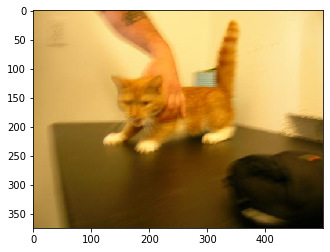

In [9]:
cats = os.path.join(os.getcwd(),"PetImages\\Cat")
path = os.path.join(os.getcwd(),cats,os.listdir(cats)[0])
img = plt.imread(path)
plt.imshow(img)
plt.show()
cv2.imshow("Cat",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Well thats a cute doggo!

### Creating Dataset class

The dataset object recieves numpy array which have images in Channels-last format. Pytorch likes her channels first. So we tranpose the array. Any other transform passed as argument is also performed. Then the image and label is returned as tuple.

In [33]:
class dataset(Dataset):
    def __init__(self, data, transform = None, test = False):
        self.data = data
        self.Size = round(self.data.shape[0]/10)
        if test:
            self.data = self.data[-self.Size:]
        else:
            self.data = self.data[:-self.Size]
        self.len = self.data.shape[0]
        self.transform = transform
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        X,Y = self.data[idx]
        if self.transform:
            self.transform = transforms.Compose([self.transform,transforms.ToTensor()])
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])
        X = self.transform(X)
        return X,Y

###  Defining custom Module for VGG-16

The general architecture of VGG-16 is very simple. Instead of varying hyperparameters, it uses repititive blocks with same hyperparameters and relies on its depth for learning complex features. A side effect is that VGG-16 requires a very long time to train. Training locally on ImageNet would probably take a month. We will define our custom module block wise.
<img src = "https://neurohive.io/wp-content/uploads/2018/11/vgg16.png" width = 800>


In [45]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()
        #Block 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, )
        #Block 2
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='relu')
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv4.weight, nonlinearity='relu')
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #Block 3
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv5.weight, nonlinearity='relu')
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv6.weight, nonlinearity='relu')
        self.conv7 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv7.weight, nonlinearity='relu')
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #Block 4
        self.conv8 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv8.weight, nonlinearity='relu')
        self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv9.weight, nonlinearity='relu')
        self.conv10 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv10.weight, nonlinearity='relu')
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #Block 5
        self.conv11 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv11.weight, nonlinearity='relu')
        self.conv12 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv12.weight, nonlinearity='relu')
        self.conv13 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        nn.init.kaiming_uniform_(self.conv13.weight, nonlinearity='relu')
        self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #Block 6
        self.fc1 = nn.Linear(in_features = 25088, out_features = 4096)
        self.fc2 = nn.Linear(in_features = 4096, out_features = 4096)
        self.fc2 = nn.Linear(in_features = 4096, out_features = 2)
        self.output = nn.Softmax(dim = 1)
    def forward(self,X):
        #Block 1
        X = self.conv1(X)
        X = F.relu(X)
        X = self.conv2(X)
        X = F.relu(X)
        X = self.pool1(X)
        #Block 2
        X = self.conv3(X)
        X = F.relu(X)
        X = self.conv4(X)
        X = F.relu(X)
        X = self.pool2(X)
        #Block3
        X = self.conv5(X)
        X = F.relu(X)
        X = self.conv6(X)
        X = F.relu(X)
        X = self.conv7(X)
        X = F.relu(X)
        X = self.pool3(X)
        #Block 4
        X = self.conv8(X)
        X = F.relu(X)
        X = self.conv9(X)
        X = F.relu(X)
        X = self.conv10(X)
        X = F.relu(X)
        X = self.pool4(X)
        #Block 5
        X = self.conv11(X)
        X = F.relu(X)
        X = self.conv12(X)
        X = F.relu(X)
        X = self.conv13(X)
        X = F.relu(X)
        X = self.pool5(X)
        #Block 6
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = self.output(X)
        return X
    

That a huge class. Phew!

In [71]:
def train_model(model,optimizer,criterion, train_loader, test_loader, EPOCHS):
    '''
    Function for training the neural network.
    '''
    try:
        assert TEST_SIZE!= None
    except:
        print("Test size is not known. I need it to calculate accuracy.")
    TRAIN_LOSS = []
    ACCURACY = []    #Accuracy on test set
    model.train()
    for epoch in range(EPOCHS):
        print("Epoch: ",epoch)
        print("\tTraining-")
        LOSS = 0        
        for x,y in tqdm(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat,y)
            loss.backward()
            optimizer.step()
            LOSS+= loss.data
        TRAIN_LOSS.append(LOSS)
    model.eval()
    print("\tValidating")
    correct = 0
    with torch.no_grad():
        for x,y in tqdm(test_loader):
            x = x.to(device)
            y = y.to(device)
            yhat = model(x)
            _,label = torch.max(yhat.data,1)
            correct += (label==y).sum.item()
        accuracy = correct/TEST_SIZE*100
        print("Test set accuracy for epoch ",epoch," = ", accuracy,"%")
        ACCURACY.append(accuracy)
    data = {"Loss":TRAIN_LOSS, "Accuracy":ACCURACY}
    return model,optimizer, data        

In [13]:
data = np.load("training_data.npy", allow_pickle = True)

In [99]:
train_data = dataset(data)
test_data = dataset(data, test=True)

In [87]:
model = VGG16()
model.to(device)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size = 256)
test_loader = DataLoader(test_data, batch_size = 2500)
optimizer = torch.optim.Adam(model.parameters()) #Default learning rate is 0.001

In [95]:
train_data

In [20]:
debug_X = torch.randn((224,224,3))
debug_Y = 1

In [73]:
TEST_SIZE = 10
debug_data = dataset(data[:TEST_SIZE])
debug_loader = DataLoader(debug_data)

In [ ]:

Model, Optimizer, Data = train_model(model, optimizer, criterion,debug_loader, debug_loader,1)
torch.save(Model.state_dict(),os.path.join(os.getcwd(),"debug_model"))

In [101]:
type(train_data[0])

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>